# Cryptocurrency Trading Strategy

### This notebook details the process I used to:

1. Scrape exchange rate data
2. Formulate a trading strategy using a simple moving average crossover
3. Backtest that strategy using historical data
4. Evaluate and determine the values that could potentially yield the best returns

### Conlusions:

1. If this strategy was used for BTC and XRP and implemented in an algorithmic trading bot, a trader could've had a return of at least 200000% if they implemented it sometime in early 2017 (as of Jan 2018).
2. In a future project I will code an algorithmic trading bot that implements this strategy and interacts with an exchange's API to send buy and sell signals.

### Recommendations:

1. These incredible returns are caused by a number of factors, including the alt coin boom, XRP's boom in particular, and assumptions that there are no transaction costs.
2. This strategy worked well with historical data, but past performance is not indicative of future results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def CryptoData(symbol, frequency):
    #Parameters: String symbol, int frequency = 300,900,1800,7200,14400,86400
    #Returns: df from first available date
    url ='https://poloniex.com/public?command=returnChartData&currencyPair='+symbol+'&end=9999999999&period='+str(frequency)+'&start=0'
    df = pd.read_json(url)
    df.set_index('date',inplace=True)
    return df

In [3]:
df = CryptoData(symbol = 'BTC_XRP', frequency = 300)
#When frequency = 300, data is refreshed every 5 minutes

We are interested developing a simple moving average (SMA) crossover strategy for trading Bitcoin and Ripple. A crossover is a relatively basic trading strategy that identifies shifts in price momentum that can be used as buy or sell signals. Our crossover strategy will consisit of a leading SMA and a lagging SMA. Leading SMA or the "short-term average" has less periods when calculating the average, so it is more sensitive to recent price changes. Lagging SMA or the "long-term average" has more periods, so it is less sensitive to recent price changes.

Text(0,0.5,'Price')

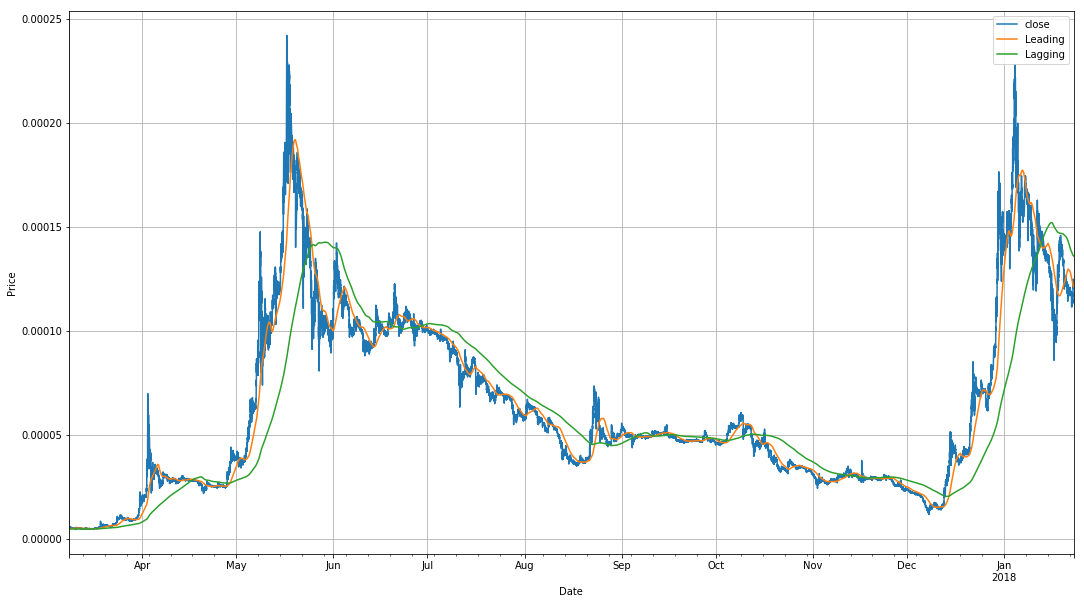

In [4]:
df['Leading'] = df['close'].rolling(1000).mean()
df['Lagging'] = df['close'].rolling(5000).mean()
df[['close','Leading','Lagging']][270000:].plot(figsize = (18,10), grid = True)
plt.xlabel('Date')
plt.ylabel('Price')

Trading Strategy: 
1. BUY if Leading SMA is ABOVE Lagging SMA by a certain threshold
2. SELL if Leading SMA is BELOW Lagging Simple Moving Avg. by a certain threshold

In [5]:
def test_ma(df, lead, lag, pc_thresh = 0.025):
    ma_df = df.copy()
    ma_df['lead'] = ma_df['close'].rolling(lead).mean()
    ma_df['lag'] = ma_df['close'].rolling(lag).mean()
    ma_df.dropna(inplace = True)
    ma_df['lead-lag'] = ma_df['lead'] - ma_df['lag']
    ma_df['pc_diff'] = ma_df['lead-lag'] / ma_df['close']
    ma_df['regime'] = np.where(ma_df['pc_diff'] > pc_thresh, 1, 0)
    ma_df['regime'] = np.where(ma_df['pc_diff'] < -pc_thresh, -1, ma_df['regime'])
    ma_df['Market'] = np.log(ma_df['close'] / ma_df['close'].shift(1))
    ma_df['Strategy'] = ma_df['regime'].shift(1) * ma_df['Market']
    ma_df[['Market','Strategy']] = ma_df[['Market','Strategy']].cumsum().apply(np.exp)
    return ma_df

The 'regime' column dictates the buying and selling logic. When the value changes to 1, we buy, and then we don't sell until it changes to -1. A 0 would mean we have no position and wait until the next buy or sell signal. The 'Market' column is the log returns of the change in price between BTC and XRP. The 'Strategy' column is our returns when using the SMA crossover strategy. It is computed by multipling 'regime' (shifted forward to match the 'Market' column) by 'Market'

In [6]:
ma_df = test_ma(df, 1000, 5000).dropna()
ma_df.tail()

,close,high,low,open,quoteVolume,volume,weightedAverage,Leading,Lagging,lead,lag,lead-lag,pc_diff,regime,Market,Strategy
date,,,,,,,,,,,,,,,,
2018-01-23 04:15:00,0.000122,0.000122,0.000121,0.000122,75832.798024,9.203422,0.000121,0.000121,0.000136,0.000121,0.000136,-0.000015,-0.121000,-1,14.297647,886.477724
2018-01-23 04:20:00,0.000121,0.000122,0.000121,0.000122,41889.779548,5.088410,0.000121,0.000121,0.000136,0.000121,0.000136,-0.000015,-0.121383,-1,14.258824,888.891401
2018-01-23 04:25:00,0.000121,0.000122,0.000121,0.000121,37580.174772,4.559464,0.000121,0.000121,0.000136,0.000121,0.000136,-0.000015,-0.121301,-1,14.272941,888.012181
2018-01-23 04:30:00,0.000122,0.000122,0.000121,0.000121,7256.816560,0.881059,0.000121,0.000121,0.000136,0.000121,0.000136,-0.000015,-0.120916,-1,14.322353,884.948561
2018-01-23 04:35:00,0.000122,0.000122,0.000122,0.000122,6449.649136,0.784109,0.000122,0.000121,0.000136,0.000121,0.000136,-0.000015,-0.121122,-1,14.301176,886.258949


In [7]:
ma_df[['Market','Strategy']].iloc[-1]

#Would have outperformed the market by a factor of about 46

Market       14.301176
Strategy    886.258949
Name: 2018-01-23 04:35:00, dtype: float64

Text(0,0.5,'BTC_XRP Return')

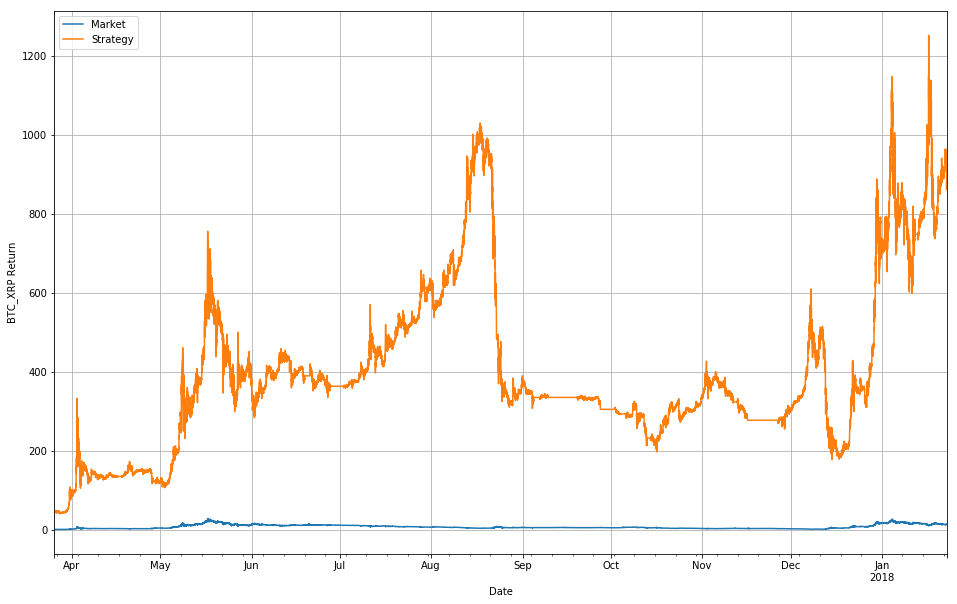

In [8]:
ma_df[['Market','Strategy']][270000:].plot(figsize = (16,10), grid = True)
plt.xlabel('Date')
plt.ylabel('BTC_XRP Return')

We can improve on the lead and lag moving average strategy by finding the combination of values that yields the highest return or profit and loss (PnL). We can create an array of lead and lag pairs, loop over the array with the returns using our strategy create a heatmap to indentify the best pairs.

In [9]:
leads = np.arange(100, 4100, 100)
lags = np.arange(4100, 8100, 100)
lead_lags = [[lead,lag] for lead in leads for lag in lags]
pnls = pd.DataFrame(index=lags,columns = leads)

In [16]:
%%capture

for lead, lag in lead_lags:
    pnls[lead][lag] = test_ma(df, lead, lag)['Strategy'][-1]
    print(lead,lag,pnls[lead][lag])
    
#Output is hidden because it includes 1,600 rows

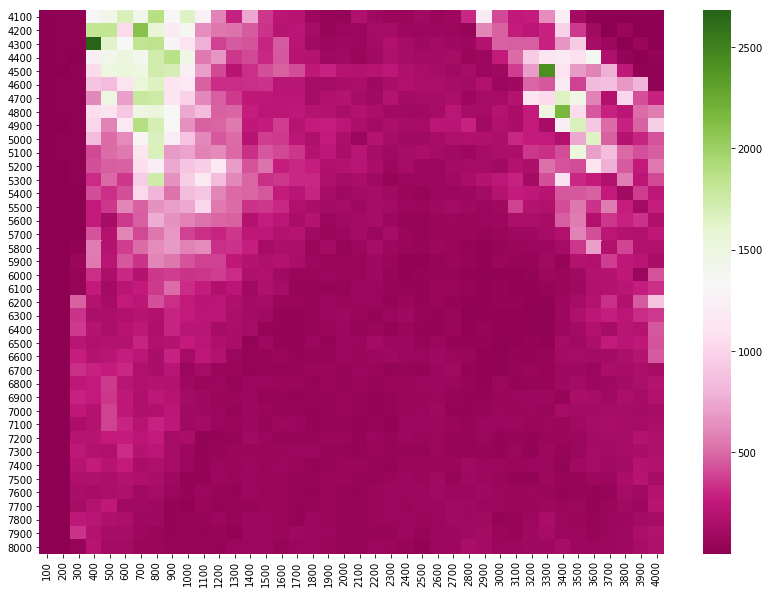

In [17]:
PNLs = pnls[pnls.columns].astype(float)
plt.subplots(figsize = (14,10))
sns.heatmap(PNLs,cmap= 'PiYG')

In [19]:
PNLs.max()

100        6.667852
200       18.635301
300      476.569436
400     2683.361494
500     1826.874262
600     1679.960843
700     2098.811519
800     1879.180563
900     1869.819334
1000    1647.184688
1100    1267.299335
1200    1171.448545
1300     697.823281
1400     742.194618
1500     526.203275
1600     481.439601
1700     415.164670
1800     312.610167
1900     286.001018
2000     227.236945
2100     212.198057
2200     205.087884
2300     241.596147
2400     170.018375
2500     150.694514
2600     221.040802
2700     229.093761
2800     312.281984
2900    1190.459858
3000     476.362516
3100     509.217318
3200    1116.029582
3300    2428.365990
3400    2171.969158
3500    1684.407089
3600    1647.382197
3700     868.918353
3800    1016.119087
3900     802.405115
4000     963.938341
dtype: float64

A lead of 400 periods and lag of 4300 periods produces the max PnL.

Text(0,0.5,'Price')

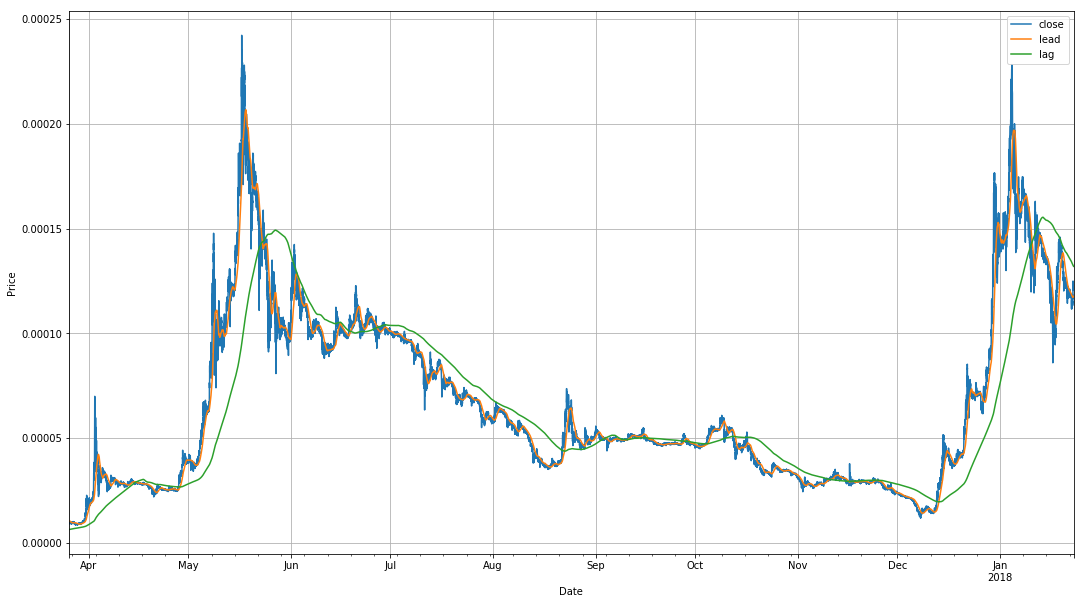

In [20]:
optimal_ma_df = test_ma(df, 400, 4300).dropna()
optimal_ma_df[['close','lead','lag']][270000:].plot(figsize = (18,10), grid = True)
plt.xlabel('Date')
plt.ylabel('Price')

Text(0,0.5,'BTC_XRP Return')

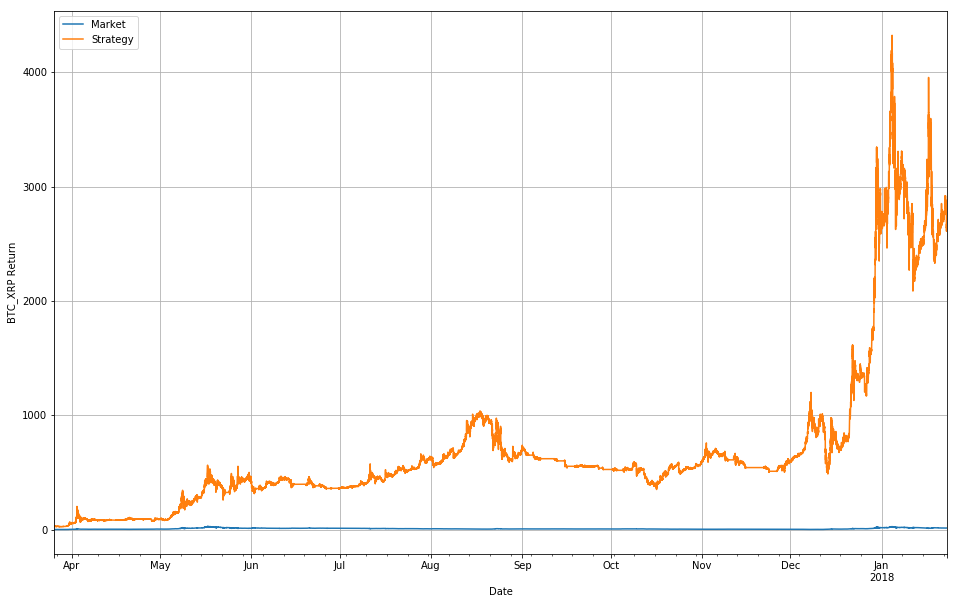

In [21]:
optimal_ma_df[['Market','Strategy']][270000:].plot(figsize = (16,10), grid = True)
plt.xlabel('Date')
plt.ylabel('BTC_XRP Return')

### Conlusions:

1. If this strategy was used for BTC and XRP and implemented in an algorithmic trading bot, a trader could've had a return of at least 200000% if they implemented it sometime in early 2017 (as of Jan 2018).
2. In a future project I will code an algorithmic trading bot that implements this strategy and interacts with an exchange's API to send buy and sell signals.

### Recommendations:

1. These incredible returns are caused by a number of factors, including the alt coin boom, XRP's boom in particular, and assumptions that there are no transaction costs.
2. This strategy worked well with historical data, but past performance is not indicative of future results.